Demonstration of GPR for infant mortality data in Miller (2015) with proposed accountability measure in LLM (2020)

Miller, Michael K. "Electoral authoritarianism and human development." Comparative Political Studies 48.12 (2015): 1526-1562.

LÜHRMANN, A., MARQUARDT, K., & MECHKOVA, V. (2020). Constraining Governments: New Indices of Vertical, Horizontal, and Diagonal Accountability. American Political Science Review, 114(3), 811-820.

In [1]:
# load packages
import torch
import numpy as np
import pandas as pd
from scipy.stats import norm
import gpytorch
from typing import Optional, Tuple
from matplotlib import pyplot as plt
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

Implement constant mean module and mask mean module

In [2]:
class ConstantVectorMean(gpytorch.means.mean.Mean):
    def __init__(self, d=1, prior=None, batch_shape=torch.Size(), **kwargs):
        super().__init__()
        self.batch_shape = batch_shape
        self.register_parameter(name="constantvector",\
                 parameter=torch.nn.Parameter(torch.zeros(*batch_shape, d)))
        if prior is not None:
            self.register_prior("mean_prior", prior, "constantvector")

    def forward(self, input):
        return self.constantvector[input.int().reshape((-1,)).tolist()]
    
class MaskMean(gpytorch.means.mean.Mean):
    def __init__(
        self,
        base_mean: gpytorch.means.mean.Mean,
        active_dims: Optional[Tuple[int, ...]] = None,
        **kwargs,
    ):
        super().__init__()
        if active_dims is not None and not torch.is_tensor(active_dims):
            active_dims = torch.tensor(active_dims, dtype=torch.long)
        self.active_dims = active_dims
        self.base_mean = base_mean
    
    def forward(self, x, **params):
        return self.base_mean.forward(x.index_select(-1, self.active_dims), **params)

load data

In [3]:
# read data and drop NA
data = pd.read_csv("accountability_data_regressions.csv", index_col=[0])
# data = data[~data.infant.isna()]
data = data[["infant", "Accountability", "aid", "loggdp", "gdp_grow",\
            "resourcesdep_hm", "gini2", "lnpop", "urban_cow", "country_name", \
            "violence_domestic", "communist", "rx_infant", "v2x_corr", "Vertical", "Horizontal"]]

data = data.dropna()

countries = sorted(data.country_name.unique())
data["year"] = data.index.values
years = data.index.unique()
n = len(countries)
m = len(years)

# build data
country_dict = dict(zip(countries, range(n)))
year_dict = dict(zip(years, range(m)))

# x is:
# 0: year number
# 1: country id
# 2: Accountability (regressor of interests)
# 3: aid
# 4: loggdp
# 5: gdp_grow
# 6: resourcesdep_hm
# 7: gini2
# 8: lnpop
# 9: urban_cow
# 10: rx_infant
# 11: v2x_corr 
# 12: violence_domestic
# 13: communist
# 14: Vertical
# 15: Horizontal

x = torch.zeros(data.shape[0], 16)
x[:,0] = torch.as_tensor(list(map(year_dict.get, data.index)))
x[:,1] = torch.as_tensor(list(map(country_dict.get, data.country_name)))
x[:,2] = torch.as_tensor(data.Accountability.to_numpy())
x[:,3] = torch.as_tensor(data.aid.to_numpy())
x[:,4] = torch.as_tensor(data.loggdp.to_numpy())
x[:,5] = torch.as_tensor(data.gdp_grow.to_numpy())
x[:,6] = torch.as_tensor(data.resourcesdep_hm.to_numpy())
x[:,7] = torch.as_tensor(data.gini2.to_numpy())
x[:,8] = torch.as_tensor(data.lnpop.to_numpy())
x[:,9] = torch.as_tensor(data.urban_cow.to_numpy())
x[:,10] = torch.as_tensor(data.rx_infant.to_numpy())
x[:,11] = torch.as_tensor(data.v2x_corr.to_numpy())
x[:,12] = torch.as_tensor(data.violence_domestic.to_numpy())
x[:,13] = torch.as_tensor(data.communist.to_numpy())
x[:,14] = torch.as_tensor(data.Vertical.to_numpy())
x[:,15] = torch.as_tensor(data.Horizontal.to_numpy())
y = torch.as_tensor(data.infant.to_numpy()).float()

train_x, train_y = x.float(), y.float()


Build GPR model with unit trends

In [4]:
# model specification: gp model with unit trends
# infant ~ Accountability + aid + loggdp + gdp_grow +
#    resourcesdep_hm + gini2 + lnpop + urban_cow + 
#    violence_domestic + communist + rx_infant + v2x_corr + u_i(t)
# u_i(t) ~ GP(b_i, K)
# K = K_x + K_t*K_{spatial}

class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, n_country):
        # variational_distribution = CholeskyVariationalDistribution(train_x.size()[0])
        # variational_strategy = VariationalStrategy(
        #     self, train_x, variational_distribution, learn_inducing_locations=False
        # )
        # super(GPModel, self).__init__(variational_strategy)
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        # unit mean by country
        self.unit_mean_module = MaskMean(active_dims=1, base_mean=ConstantVectorMean(d=n_country))
        # year kernel * country kernel
        self.unit_covar_module = ScaleKernel(RBFKernel(active_dims=0)*RBFKernel(active_dims=[14,15]))
        # adopt a product kernel of continuous inputs and categorical inputs
        self.x_covar_module = ScaleKernel(RBFKernel(active_dims=[2,3,4,5,6,7,8,9,10,11], ard_num_dims=10))
        # linear mean for continuous covariates
        self.x_mean_module = MaskMean(active_dims=[2,3,4,5,6,7,8,9,10,11], base_mean=LinearMean(input_size=10, bias=False))
        # dummy mean for categorical covariates
        self.categorical_mean_module = torch.nn.modules.ModuleList([MaskMean(active_dims=12, base_mean=ConstantVectorMean(d=11)),\
                                                                    MaskMean(active_dims=13, base_mean=ConstantVectorMean(d=2))])

    def forward(self, x):
        mean_x = self.unit_mean_module(x) + self.x_mean_module(x)
        for i in range(len(self.categorical_mean_module)):
            mean_x += self.categorical_mean_module[i](x)
        # K = K_country * K_year + K_continuous 
        covar_x = self.x_covar_module(x) + self.unit_covar_module(x)
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

build a 2FE model

In [5]:
import statsmodels.formula.api as sm

lm = sm.ols('infant~ Accountability + aid + loggdp + gdp_grow + \
                        resourcesdep_hm + gini2 + lnpop + urban_cow + \
                        C(country_name) + C(year)  + C(violence_domestic) + C(communist) + \
                        + rx_infant + v2x_corr - 1', data).fit()
# print(lm.summary())
coefs = lm.params.to_dict()
year_effects = np.zeros((m,))
country_effects = np.zeros((n,))
violence_effects = np.zeros((11,))
communist_effects = np.zeros((2,))
for i in range(1,m):
    year_effects[i] = coefs['C(year)[T.' + str(years[i]) + ']']
for i in range(n):
    country_effects[i] = coefs['C(country_name)[' + countries[i] + ']']
for i in range(1,11):
    violence_effects[i] = coefs['C(violence_domestic)[T.' + str(i) + '.0]']
communist_effects[1] = coefs['C(communist)[T.1.0]']
noise_var = lm.scale
year_os = np.max(np.abs(year_effects))**2

covariate_names = ["Accountability", "aid", "loggdp","gdp_grow", \
                        "resourcesdep_hm","gini2","lnpop","urban_cow", \
                       "rx_infant", "v2x_corr"]
x_weights = list(map(coefs.get, covariate_names))
x_os = np.max(np.abs(list(map(lm.bse.to_dict().get, covariate_names))))**2


initialize model

In [6]:
likelihood = GaussianLikelihood()
likelihood.noise = 4 
# N = train_x.size()[0]
# inducing_points = train_x[torch.randperm(N)[:(N//20)]]
model = GPModel(train_x, train_y, likelihood, n)

# initialize model parameters
hypers = {
    'unit_mean_module.base_mean.constantvector': torch.tensor(country_effects),
    'unit_covar_module.base_kernel.kernels.0.lengthscale': torch.tensor(10),
    'unit_covar_module.base_kernel.kernels.1.lengthscale': torch.tensor(1),
    'unit_covar_module.outputscale': torch.tensor(year_os),
    'x_mean_module.base_mean.weights': torch.tensor(x_weights),
    'x_covar_module.outputscale': torch.tensor(x_os),
    'categorical_mean_module.0.base_mean.constantvector': torch.tensor(violence_effects),
    'categorical_mean_module.1.base_mean.constantvector': torch.tensor(communist_effects)
}    

model.initialize(**hypers)

GPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (unit_mean_module): MaskMean(
    (base_mean): ConstantVectorMean()
  )
  (unit_covar_module): ScaleKernel(
    (base_kernel): ProductKernel(
      (kernels): ModuleList(
        (0): RBFKernel(
          (raw_lengthscale_constraint): Positive()
        )
        (1): RBFKernel(
          (raw_lengthscale_constraint): Positive()
        )
      )
    )
    (raw_outputscale_constraint): Positive()
  )
  (x_covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
  (x_mean_module): MaskMean(
    (base_mean): LinearMean()
  )
  (categorical_mean_module): ModuleList(
    (0): MaskMean(
      (base_mean): ConstantVectorMean()
    )
    (1): MaskMean(
      (base_mean): ConstantVectorMean()
    )
  )
)

train model by optimizing hypers

In [7]:
# train model
model.train()
likelihood.train()

torch.manual_seed(12345)

# freeze length scale in the country component in unit covar
# freeze constant unit means
all_params = set(model.parameters())
final_params = list(all_params - \
            {model.unit_covar_module.base_kernel.kernels[1].raw_lengthscale})

# optimizer = torch.optim.Adam([
#     {'params': final_params},
#     {'params': likelihood.parameters()},
# ], lr=0.1)
optimizer = torch.optim.Adam(final_params, lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# loss_diff = 1
# last_loss = 200
# iter = 0
# while(loss_diff>=1e-2):
for iter in range(50):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    if iter % 5 == 0:
        print('Iter %d - Loss: %.3f '  % (
            iter, loss.item()
        ))
    # loss_diff = np.abs(last_loss-loss.item())
    # last_loss = loss.item()
    optimizer.step() 
    # iter += 1

torch.save(model.state_dict(), "AIM_GPR_model.pth")

/Users/yahoo/anaconda3/lib/python3.7/site-packages/gpytorch/functions/_pivoted_cholesky.py:118: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  [L, torch.triangular_solve(Krows[..., m:, :].transpose(-1, -2), L, upper=False)[0].transpose(-1, -2)],


Iter 0 - Loss: 5.814 
Iter 5 - Loss: 5.697 
Iter 10 - Loss: 5.149 
Iter 15 - Loss: 4.657 
Iter 20 - Loss: 4.273 
Iter 25 - Loss: 4.038 
Iter 30 - Loss: 3.833 
Iter 35 - Loss: 3.658 
Iter 40 - Loss: 3.536 
Iter 45 - Loss: 3.437 


generate posterior; compute RMSE

In [8]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x))

RMSE = np.square((observed_pred.mean - train_y).detach().numpy()).mean()**0.5
print(RMSE)

/Users/yahoo/anaconda3/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


2.3345288778754743


use autogradient to generate posterior variance of marginal effects by small batches

In [11]:
model.eval()
likelihood.eval()

df_std = np.zeros((train_x.size(0),train_x.size(1)))
x_grad = np.zeros((train_x.size(0),train_x.size(1)))

n_samples = 100
sampled_dydtest_x = np.zeros((n_samples, train_x.size(0),train_x.size(1)))

# small batches of size 100
evidence_gp = 0
for i in range(train_x.size(0)//100):
    with gpytorch.settings.fast_pred_var():
        test_x = train_x[(i*100):(i*100+100)].clone().detach().requires_grad_(True)
        observed_pred = model(test_x)
        dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
        x_grad[(i*100):(i*100+100)] = dydtest_x
        loss = mll(observed_pred, train_y[(i*100):(i*100+100)])
        evidence_gp += loss.item() * observed_pred.mean.size(0)

        sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
        sampled_dydtest_x[:,(i*100):(i*100+100),:] = torch.stack([torch.autograd.grad(pred.sum(), test_x, retain_graph=True)[0] for pred in sampled_pred])
        # df_std[(i*100):(i*100+100)] = sampled_dydtest_x.std(0)
        
# last 100 rows
with gpytorch.settings.fast_pred_var():
    test_x = train_x[(100*i+100):].clone().detach().requires_grad_(True)
    observed_pred = model(test_x)
    dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
    x_grad[(100*i+100):] = dydtest_x
    loss = mll(observed_pred, train_y[(100*i+100):])
    evidence_gp += loss.item() * observed_pred.mean.size(0)

    sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
    sampled_dydtest_x[:,(100*i+100):,:] = torch.stack([torch.autograd.grad(pred.sum(), test_x, retain_graph=True)[0] for pred in sampled_pred])
    # df_std[(100*i+100):] = sampled_dydtest_x.std(0)

accesse marginal effects of regressors including accountability

In [12]:
est_std = np.sqrt(sampled_dydtest_x.mean(1).std(0)**2 + sampled_dydtest_x.std(1).mean(0)**2)
est_std.round(decimals=5)

results = pd.DataFrame({"x": covariate_names, \
                        'est_mean': x_grad.mean(axis=0)[2:12],
                        'est_std': est_std[2:12]})
results["t"] = results['est_mean'].values/results['est_std'].values
results["pvalue"] = 1-norm.cdf(np.abs(results["t"].values))
print(results)

                 x   est_mean    est_std          t    pvalue
0   Accountability  -4.292333   0.394975 -10.867367  0.000000
1              aid  -0.037023   0.434933  -0.085123  0.466082
2           loggdp -10.252744  17.839062  -0.574736  0.282735
3         gdp_grow   0.021200   1.327237   0.015973  0.493628
4  resourcesdep_hm   0.009873   1.167602   0.008456  0.496627
5            gini2  -0.001887   1.388718  -0.001359  0.499458
6            lnpop -17.964225   9.356747  -1.919922  0.027434
7        urban_cow  -0.075183   1.730842  -0.043437  0.482677
8        rx_infant   0.634666   2.384402   0.266174  0.395053
9         v2x_corr  -3.723241  13.178952  -0.282514  0.388775


compare model evidence and BIC

In [13]:
evidence_lm = lm.llf

num_params = 0
for p in final_params:
    num_params += p.reshape((-1,1)).size(0)
bic_gp = num_params*np.log(train_x.size(0)) + 2*loss.item()
bic_lm = lm.bic

print("lm evidence: {:.2f}\n".format(evidence_lm))
print("gpm evidence: {:.2f}\n".format(evidence_gp))
print("lm bic: {:.2f}\n".format(bic_lm))
print("gpm bic: {:.2f}\n".format(bic_gp))

lm evidence: -15435.67

gpm evidence: -10117.09

lm bic: 32664.42

gpm bic: 1537.29



plotted fitted mean

In [15]:
model.load_state_dict(torch.load('AIM_GPR_model.pth'))

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out = model(train_x)
    mu_f = out.mean.numpy()
    lower, upper = out.confidence_region()

results = pd.DataFrame({"gpr_mean":mu_f})
results['true_y'] = train_y
results['gpr_lwr'] = lower
results['gpr_upr'] = upper
results['vertical'] = data.Vertical.to_numpy()
results['horizontal'] = data.Horizontal.to_numpy()
results['year'] = years[train_x[:,0].numpy().astype(int)]
results['country'] = [countries[i] for i in train_x[:,1].numpy().astype(int)]
print(results.head())
results.to_csv("./results/AIM_fitted_gpr.csv",index=False) #save to file

/Users/yahoo/anaconda3/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


     gpr_mean     true_y    gpr_lwr     gpr_upr  vertical  horizontal  year  \
0  103.883003  97.199997  97.603287  110.162720 -0.153552   -1.248443  1960   
1  100.549744  95.300003  94.849419  106.250069 -0.160106   -1.251883  1961   
2   97.662560  93.199997  92.224167  103.100952 -0.161721   -1.241928  1962   
3   95.025436  91.400002  89.680565  100.370308 -0.160987   -1.243880  1963   
4   94.167389  89.599998  88.746696   99.588081 -0.160747   -1.253736  1964   

  country  
0  Mexico  
1  Mexico  
2  Mexico  
3  Mexico  
4  Mexico  


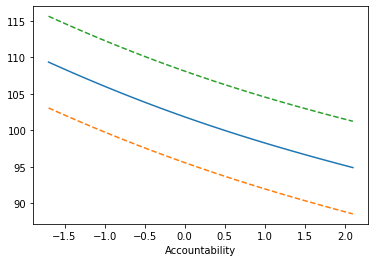

In [19]:
model.load_state_dict(torch.load('AIM_GPR_model.pth'))

model.eval()
likelihood.eval()

test_x = train_x[0:101].clone().detach().requires_grad_(False)
for i in range(100):
    test_x[1+i] = test_x[0].clone().detach().requires_grad_(True)
test_x[:,2] = torch.linspace(-1.7,2.1,101)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out = model(test_x)
    mu_f = out.mean.numpy()
    lower, upper = out.confidence_region()
    plt.plot(test_x[:,2].detach().numpy(), mu_f)
    plt.plot(test_x[:,2].detach().numpy(), lower.numpy(), '--')
    plt.plot(test_x[:,2].detach().numpy(), upper.numpy(), '--')
    plt.xlabel("Accountability")